In [1]:
# mount drive and change directory to project folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/520 Final Project"

/content/drive/.shortcut-targets-by-id/1KHBlsdIi36o_ikonJZ-usBVzGPrZlH0V/520 Final Project


#loading data

In [3]:
import numpy as np
with open("X_train_spec_db.npy", 'rb') as f:
  X_train_spec = np.load(f)
with open("X_test_spec_db.npy", 'rb') as f:
  X_test_spec = np.load(f)
with open("y_train_spec.npy", 'rb') as f:
  y_train_spec = np.load(f)[:,40:85]
with open("y_test_spec.npy", 'rb') as f:
  y_test_spec = np.load(f)[:,40:85]

In [4]:
X_train_spec.shape, y_train_spec.shape, X_test_spec.shape, y_test_spec.shape

((326580, 84, 32), (326580, 45), (3981, 84, 32), (3981, 45))

#messing around with librosa

In [ ]:
import matplotlib.pyplot as plt
import librosa
import librosa.display

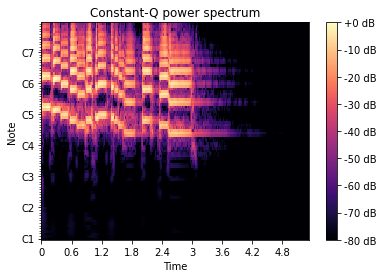

In [ ]:
y, sr = librosa.load(librosa.ex('trumpet')) #5 second long audio file
C = np.abs(librosa.cqt(y, sr=sr))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max), sr=sr, x_axis='time', y_axis='cqt_note', ax=ax)
ax.set_title('Constant-Q power spectrum')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [ ]:
C.shape

(84, 230)

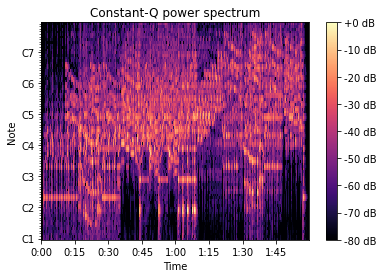

In [ ]:
y, sr = librosa.load(librosa.ex('nutcracker')) #1 minute 59 seconds
C = np.abs(librosa.cqt(y, sr=sr))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max), sr=sr, x_axis='time', y_axis='cqt_note', ax=ax)
ax.set_title('Constant-Q power spectrum')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [ ]:
C.shape

(84, 5163)

#okay back to work

In [5]:
import os
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torch import nn, optim
from matplotlib import pyplot as plt

In [6]:
#needs to take a 84 x 32 and get a 45
class CNN1(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1, padding=1)
    self.batch_1 = nn.BatchNorm2d(4)
    self.conv_2 = torch.nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = 5, stride = 1, padding = 1)
    self.batch_2 = nn.BatchNorm2d(8)
    self.linear_1 = torch.nn.Linear(912, 128)
    self.linear_2 = torch.nn.Linear(128, 45)
    self.relu = torch.nn.ReLU()
    self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.dropout = nn.Dropout(p = 0.5)
  def forward(self, x):
      x = x.reshape((x.size(0), 1, x.size(1), x.size(2))) #as CNN expects [B, Cin, H, W] as output, converts from [B, H, W] --> [B, Cin, H, W]
      x = self.relu(self.conv_1(x))
      x = self.batch_1(x)
      x = self.max_pool2d(x)
      x = self.relu(self.conv_2(x))
      x = self.batch_2(x)
      x = self.max_pool2d(x)
      x = self.dropout(x)

      x = x.reshape((x.size(0), -1))
      x = self.relu(self.linear_1(x))
      x = self.linear_2(x)
      return x

#training the model (don't run again)

In [ ]:
#put data into trainloader
trainset = []
for i in range(len(X_train_spec)):
  trainset.append([X_train_spec[i], y_train_spec[i]])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

In [ ]:
epochs = 5
model = CNN1()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3) 
train_loss = []
# training iteration
for epoch in range(epochs):
    running_loss = 0
    for itr, (image, label) in enumerate(trainloader):
        #print("image: " + str(image.shape))
        # zero gradient
        optimizer.zero_grad()
        # forward path
        y_predicted = model(image)
        #print("label: " + str(label.shape))
        #print("y_predicted: " + str(y_predicted.shape))
        loss = criterion(y_predicted, label)
        running_loss += loss.item()
        # backpropagating
        loss.backward()
        # optimizes the weights
        optimizer.step()
    train_loss.append(running_loss)
    print(f'epoch: {epoch+1}, loss: {running_loss:.4f}')

epoch: 1, loss: 2762.5076
epoch: 2, loss: 2539.9969
epoch: 3, loss: 2487.9743
epoch: 4, loss: 2463.4232
epoch: 5, loss: 2448.3702


In [ ]:
torch.save(model.state_dict(), 'CNNafterQTransform.pt')

#loading and testing the model

In [7]:
model2 = CNN1()
model2.load_state_dict(torch.load('CNNafterQTransform.pt'))
model2.eval()

CNN1(
  (conv_1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (batch_1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (batch_2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_1): Linear(in_features=912, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=45, bias=True)
  (relu): ReLU()
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#evaluate model here <--- so much training data, keeps using up RAM
with torch.no_grad():
  X = torch.tensor(X_train_spec).float()

NameError: ignored

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
accuracies = []
recalls = []
precisions = []
for i in range(45):
  accuracies += [accuracy_score((preds.numpy()[:,i] > 0), y_train_spec[:,i])]
  recalls += [recall_score((preds.numpy()[:,i] > 0), y_train_spec[:,i], zero_division=0)]
  precisions += [precision_score((preds.numpy()[:,i] > 0), y_train_spec[:,i], zero_division=0)]

In [ ]:
print(accuracies)
print(recalls)
print(precisions)

In [8]:
with torch.no_grad():
  X = torch.tensor(X_test_spec).float()
  preds = model2(X)

In [9]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
accuracies = []
recalls = []
precisions = []
for i in range(45):
  accuracies += [accuracy_score((preds.numpy()[:,i] > 0), y_test_spec[:,i])]
  recalls += [recall_score((preds.numpy()[:,i] > 0), y_test_spec[:,i], zero_division=0)]
  precisions += [precision_score((preds.numpy()[:,i] > 0), y_test_spec[:,i], zero_division=0)]

In [10]:
print(accuracies) #mean: 96.44
print(recalls) #mean: 71.78
print(precisions) #mean: 52.23

[0.9932177844762623, 0.9859331826174328, 0.9927153981411706, 0.984174830444612, 0.9786485807586034, 0.9826676714393369, 0.9663401155488571, 0.9869379552876162, 0.9683496608892238, 0.9914594323034414, 0.9577995478522984, 0.9409696056267269, 0.9804069329314242, 0.9721175584024114, 0.9763878422506908, 0.921627731725697, 0.9583019341873901, 0.9590555136900276, 0.923386083898518, 0.9738759105752324, 0.961818638533032, 0.9686008540567697, 0.9480030143180106, 0.9284099472494348, 0.9567947751821151, 0.9341873901029892, 0.9560411956794775, 0.9223813112283346, 0.9547852298417483, 0.9452398894750063, 0.95528761617684, 0.9640793770409445, 0.9663401155488571, 0.9655865360462196, 0.9387088671188144, 0.9507661391610148, 0.9635769907058528, 0.9643305702084903, 0.9799045465963325, 0.9507661391610148, 0.9834212509419744, 0.9816628987691535, 0.9866867621200703, 0.9886963074604371, 0.9907058528008038]
[0.7755102040816326, 0.6774193548387096, 0.8235294117647058, 0.8297872340425532, 0.8725490196078431, 0.87

In [11]:
#at middle C (index 20)
print(accuracies[20])
print(recalls[20])
print(precisions[20])

0.961818638533032
0.8278145695364238
0.49800796812749004


In [12]:
print(np.mean(recalls))
print(np.mean(precisions))

0.7178310225833316
0.5223749598895583


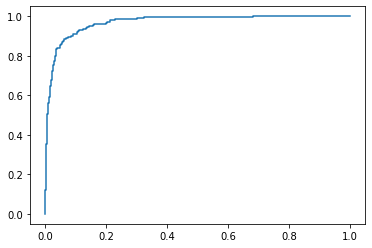

In [13]:
# ROC curve for middle C: MIDI 60, so index 20
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test_spec[:,20], preds[:,20])
plt.plot(fpr, tpr)
plt.show()

In [14]:
import pickle
with open('cnn_fpr.npy', 'wb') as f:
  np.save(f, fpr, allow_pickle=True)
with open('cnn_tpr.npy', 'wb') as f:
  np.save(f, tpr, allow_pickle=True)

In [15]:
from sklearn.metrics import auc
print(auc(fpr, tpr))

0.9696452794719246


In [16]:
# get the average AUC over all the notes
aucs = []
for i in range(45):
  fpr, tpr, _ = roc_curve(y_test_spec[:,i], preds[:,i])
  aucs += [auc(fpr,tpr)]
print(np.mean(aucs))

0.9596203691574445


In [20]:
print(np.count_nonzero(preds.numpy()[:, 0] > 0))
print(np.count_nonzero(y_test_spec[:, 0] > 0))

49
54
